# Autoencoders

## What is it?
Most of the time, it is extremely useful to know the underlying structure of the dataset. It gives you flexibility and  ideas on the labels. One way to achieve this is thru __Autoencoders__.

It is a type of Neural Network. It takes in set of typically unlabeled inputs, then after encoding, tries to reconstruct outputs as accurate as possible. Trained to reconstruct input at the output layer.
Layers:
* Encoding
* Hidden
* Decoding

<img src="figs/L6/autoenc3.png" alt="Autoencoder" style="width: 60%;"/>

Encoders are closely related to PCA, but more flexible (why? because Autoencoders introduce nonlinearities and can take advantage of neural network nature -- stacking to deep network).

<img src="figs/L6/autoenc.png" alt="Autoencoder" style="width: 30%;"/>

Oh, okay. How does it exactly work? Remember that each layer of the neural networks extract features? What if we make the hidden layer smaller than the input layer? Then no choice but __to compress__.
<img src="figs/L6/autoenc2.png" alt="Autoencoder" style="width: 30%;"/>


Autoencoders falls under the category __unsupervised learning__.

### Segue: What is unsupervised learning?

For the past few weeks, we've mostly talk about supervised learning. Here is a formal definition of it:

__Supervised learning__ is where you have input variables (x) and an output variable (Y) and you use an algorithm to learn the mapping function from the input to the output. Can be further categorized into two: classification and regression

On the other hand, here's unsupervised learning definition:

__Unsupervised learning__ is where you only have input data (X) and no corresponding output variables. The goal for unsupervised learning is to model the underlying structure or distribution in the data in order to learn more about the data.

Another category is called the __Semi-supervised learning__ wherein both supervised and unsupervised learning can be used. When? When you have a large amount of data but only a few are labeled.



## Uses and Characteristics

Characteristics
1. Data-specific - can only be used on the similar kind of data they were trained on
2. Lossy - Decompressed outputs will be degraded 
3. Self-supervised - learn by example. a specific instance of supervised learning where the targets are generated from the input data

Uses
* Extract meaningful features
* Leverage the availability of unlabeled data -- semi-supervised
* Data-dependent regularizer
* Low-dimensional representation of data -- why? saves up processing and reduces chances of overfitting.

Two interesting applications today are:
1. Data denoising
2. Dimensionality reduction for visualization
3. Sequence-to-sequence autoencoder
4. Variational autoencoder

## Requirements
1. Encoding function
2. Decoding function
3. Loss function


In [3]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import TensorBoard

## Simple Autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder

In [4]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model

In [5]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model

In [6]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).



We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [9]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s - loss: 0.3761 - val_loss: 0.2722

In [10]:
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach

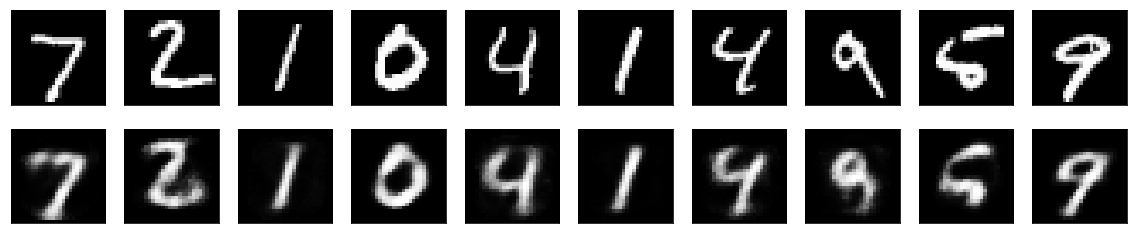

In [11]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional Autoencoders

Since we're working on images, it makes sense to make use of convolution.

In [12]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [13]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

Let's train this model for 20 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

tensorboard --logdir=/tmp/autoencoder


In [14]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 78s - loss: 0.2311 - val_loss: 0.1840

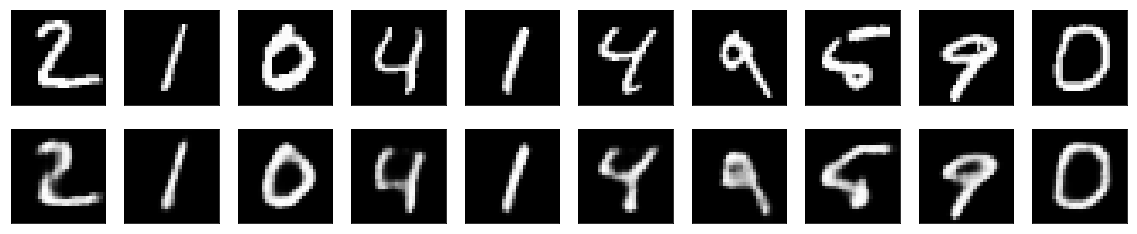

In [16]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Data denoising with Autoencoders

>Technique often used to help the network learn representations of the data that are more meaningful to the underlying data’s variability. Instead of simply training a network to recall the input it was given, random noise is applied to the input before passing it to the network — the network is still expected to recall the original (uncorrupted) input, which should force the network to stop picking up on minute details while focusing on the bigger picture - Lenny Khazan

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [17]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here are some of our generated images with noise

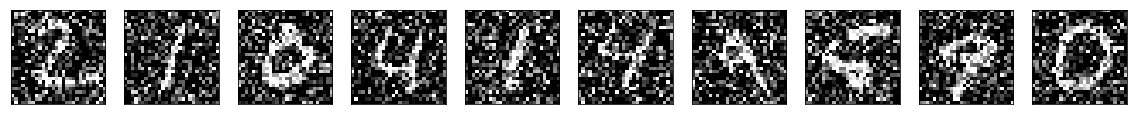

In [18]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [19]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [20]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 150s - loss: 0.2050 - val_loss: 0.1357

To view tensorboard, go to 0.0.0.0:6006.

<img src="figs/L6/tb.png" alt="TensorBoard" style="width: 100%;"/>

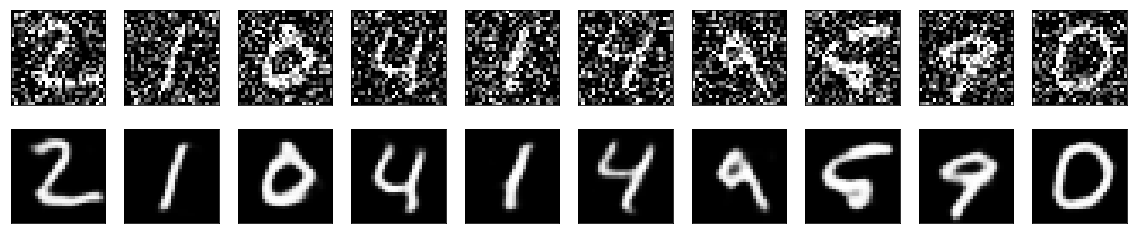

In [21]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## What else?

* Autoencoders application is __not restricted to images images__. In fact, it can also be paired up with RNN/LSTM to capture temporal property. These are known as __sequence-to-sequence models__.
* Additionally, it can also learn a latent variable model as input, this is called Variational autoencoder (VAE). VAE is a generative model.


<img src="figs/L6/vae.png" alt="Autoencoder" style="width: 60%;"/>

Credits to the following excellent tutorials:
* [Keras](!https://blog.keras.io/building-autoencoders-in-keras.html)
* [Lazy Programmer blog](!https://lazyprogrammer.me/a-tutorial-on-autoencoders/)
* [Lenny](!https://ayearofai.com/lenny-2-autoencoders-and-word-embeddings-oh-my-576403b0113a)
* [Hugo Larochelle](!https://www.youtube.com/watch?v=FzS3tMl4Nsc&t=220s)